<a href="https://colab.research.google.com/github/deema1999/Cars_Plate_Recognition_using_Yolov5/blob/main/YOLOv5_for_Cars_Plate_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu102 (Tesla T4)


In [ ]:
!echo "train: Dataset/train/images" > data/alpr.yaml
!echo "val:   Dataset/train/images" >> data/alpr.yaml

!echo "nc : 1" >> data/alpr.yaml
!echo "names: ['license']" >> data/alpr.yaml

!cat data/alpr.yaml

train: Dataset/train/images
val:   Dataset/train/images
nc : 1
names: ['license']


# Prepare Dataset

In [ ]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
# Mounting Google Drive in Colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
FILE_ROOT = "/content/gdrive/My Drive/ML/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "Dataset/"
DEST_IMAGES_PATH = "train/images"
DEST_LABELS_PATH = "train/labels"

In [ ]:
!mkdir -p Dataset/train/labels

In [ ]:
# copy images
!mkdir -p Dataset/train
!cp -rf /content/gdrive/MyDrive/ML/images Dataset/train

In [ ]:
!mkdir -p Dataset/val
!cp -rf /content/gdrive/MyDrive/ML/images/Cars1*.png Dataset/val

# Convert COCO Annotations to YOLOv5 Labels

In [ ]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]
    
def save_file(img_jpg_file_name, size, img_box):
    classes = ['license']
    save_file_name = DATA_ROOT + DEST_LABELS_PATH + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:                  
        #cls_num = classes.index(box[0]) # find class_id
        cls_num = 0
        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)
    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [ ]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

file name:  Cars0.xml
/content/gdrive/My Drive/ML/annotations/Cars0.xml
box:(c,xmin,ymin,xmax,ymax) licence 226 125 419 173
Dataset/train/labels/Cars0.txt
file name:  Cars1.xml
/content/gdrive/My Drive/ML/annotations/Cars1.xml
box:(c,xmin,ymin,xmax,ymax) licence 134 128 262 160
Dataset/train/labels/Cars1.txt
file name:  Cars10.xml
/content/gdrive/My Drive/ML/annotations/Cars10.xml
box:(c,xmin,ymin,xmax,ymax) licence 140 5 303 148
Dataset/train/labels/Cars10.txt
file name:  Cars102.xml
/content/gdrive/My Drive/ML/annotations/Cars102.xml
box:(c,xmin,ymin,xmax,ymax) licence 66 147 322 199
Dataset/train/labels/Cars102.txt
file name:  Cars107.xml
/content/gdrive/My Drive/ML/annotations/Cars107.xml
box:(c,xmin,ymin,xmax,ymax) licence 141 113 311 164
Dataset/train/labels/Cars107.txt
file name:  Cars106.xml
/content/gdrive/My Drive/ML/annotations/Cars106.xml
box:(c,xmin,ymin,xmax,ymax) licence 138 79 177 92
box:(c,xmin,ymin,xmax,ymax) licence 245 79 270 94
box:(c,xmin,ymin,xmax,ymax) licence 1

In [ ]:
!mkdir -p Dataset/val/labels
!cp -rf Dataset/train/labels/Cars1*.txt Dataset/val/labels

In [ ]:
!ls Dataset/train/labels


Cars0.txt    Cars166.txt  Cars231.txt  Cars298.txt  Cars363.txt  Cars429.txt
Cars100.txt  Cars167.txt  Cars232.txt  Cars299.txt  Cars364.txt  Cars42.txt
Cars101.txt  Cars168.txt  Cars233.txt  Cars29.txt   Cars365.txt  Cars430.txt
Cars102.txt  Cars169.txt  Cars234.txt  Cars2.txt    Cars366.txt  Cars431.txt
Cars103.txt  Cars16.txt   Cars235.txt  Cars300.txt  Cars367.txt  Cars432.txt
Cars104.txt  Cars170.txt  Cars236.txt  Cars301.txt  Cars368.txt  Cars43.txt
Cars105.txt  Cars171.txt  Cars237.txt  Cars302.txt  Cars369.txt  Cars44.txt
Cars106.txt  Cars172.txt  Cars238.txt  Cars303.txt  Cars36.txt	 Cars45.txt
Cars107.txt  Cars173.txt  Cars239.txt  Cars304.txt  Cars370.txt  Cars46.txt
Cars108.txt  Cars174.txt  Cars23.txt   Cars305.txt  Cars371.txt  Cars47.txt
Cars109.txt  Cars175.txt  Cars240.txt  Cars306.txt  Cars372.txt  Cars48.txt
Cars10.txt   Cars176.txt  Cars241.txt  Cars307.txt  Cars373.txt  Cars49.txt
Cars110.txt  Cars177.txt  Cars242.txt  Cars308.txt  Cars374.txt  Cars4.txt
Cars111.tx

In [ ]:
#pip install -U PyYAML

# YOLOv5 Training

In [ ]:
#!python train.py --img 416 --batch 16 --epochs 300 --data data/alpr.yaml --cfg models/yolov5s.yaml

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/alpr.yaml, hyp=data/hyp.scratch.yaml, epochs=300, batch_size=16, img_size=[416], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket=, cache_images=False, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-218-gc1af67d torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=

# YOLOv5 Detect

In [ ]:
#%cp /content/yolov5/yolov5/yolov5/runs/train/exp/weights/best.pt /content/gdrive/MyDrive/ML
%cp /content/gdrive/My\ Drive/ML/best.pt /content/yolov5/weights

In [ ]:
# Download OpenALPR Benchmarks
%cd ..
!git clone https://github.com/openalpr/benchmarks


/content
Cloning into 'benchmarks'...
remote: Enumerating objects: 1752, done.
remote: Total 1752 (delta 0), reused 0 (delta 0), pack-reused 1752
Receiving objects: 100% (1752/1752), 187.98 MiB | 35.44 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
!python detect.py --source /content/benchmarks/endtoend/us --conf 0.4 --weights /content/best.pt --save-txt --save-crop


detect: weights=['/content/best.pt'], source=/content/benchmarks/endtoend/us, imgsz=640, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-351-ge96c74b torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
image 1/222 /content/benchmarks/endtoend/us/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg: 384x640 1 license, Done. (0.025s)
image 2/222 /content/benchmarks/endtoend/us/12c6cb72-3ea3-49e7-b381-e0cdfc5e8960.jpg: 384x640 Done. (0.010s)
image 3/222 /content/benchmarks/endtoend/us/1e241dc8-8f18-4955-8988-03a0ab49f813.jpg: 384x640 1 license, Done. (0.011s)
image 4/222 /content/benchmarks/endtoend/us/21d8c31d-3deb-494b-9c63-c02

In [ ]:
!python detect.py --source /content/yolov5/data/images/bus.jpg --conf 0.4 --weights /content/best.pt --save-txt


detect: weights=['/content/yolov5/weights'], source=/content/yolov5/data/images/bus.jpg, imgsz=640, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-351-ge96c74b torch 1.7.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

image 1/1 /content/yolov5/data/images/bus.jpg: Traceback (most recent call last):
  File "detect.py", line 238, in <module>
    main(opt)
  File "detect.py", line 233, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 26, in decorate_context
    return func(*args, **kwargs)
  File "detect.py", line 106, in run
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
TypeError: ufunc 'true_divide' output (typecode 'd') could not be coerced to provide

In [ ]:
!python detect.py --source ../benchmarks/endtoend/br --conf 0.4 --weights /content/yolov5/weights --save-txt --save-crop


detect: weights=['/content/yolov5/weights'], source=../benchmarks/endtoend/br, imgsz=640, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-351-ge96c74b torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

image 1/115 /content/yolov5/../benchmarks/endtoend/br/AYO9034.jpg: Traceback (most recent call last):
  File "detect.py", line 238, in <module>
    main(opt)
  File "detect.py", line 233, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 28, in decorate_context
    return func(*args, **kwargs)
  File "detect.py", line 106, in run
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
TypeError: ufunc 'true_divide' output (typecode 'd') could not be coerced t

# OCR

In [ ]:
# read .txt to get x,y,w,h of ALPR
# def read_txt(filepath):
#     f = open(filepath, 'r')
#     lines = f.readlines()
         
#     # read objects from each line of .txt
#     objects = []
#     for line in lines:
#         line=line.rstrip()
#         obj = [int(float(i)) for i in line.split(' ')]
#         objects.append(obj)
#     #print(objects)
#     return objects

# OCR using PyTesseract

In [ ]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14071 sha256=5c6f9d1d08b3b6e972c062fd5d7550e3bfd72bced081a2ba8be9a9da6108e76c
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


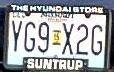

In [ ]:
DETECT_PATH = 'runs/detect/exp2/crops/license/'
IMG_NAME    = '0b86cecf-67d1-4fc0-87c9-b36b0ee228bb'
DETECT_PATH+IMG_NAME+'.jpg'
Image(DETECT_PATH+IMG_NAME+'.jpg')

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install easyocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,811 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
pip install --upgrade torch torchvision

In [ ]:
from easyocr import Reader
reader = Reader(['en'])

text =  ics-k2ch

easyocr result =  [([[2, 12], [112, 12], [112, 62], [2, 62]], 'YG9-X2G]', 0.08219666454555478), ([[25, 57], [85, 57], [85, 72], [25, 72]], 'sumtaup', 0.6055194736249576)]
---------------------------------------------
using easyocr YG9X2G
using easyocr sumtaup


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


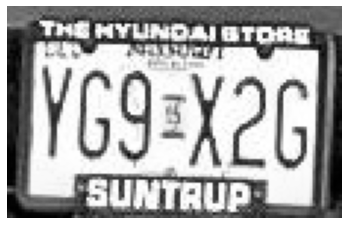

In [ ]:
import pytesseract
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import easyocr   
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract.exe'
imgg = 'runs/detect/exp2/crops/license/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg'
img_cv = cv2.imread(imgg)
img_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
plt.axis('off') 



# Apply median blur and use pytesseract
img_gray_blur = cv2.medianBlur(img_gray,1) # kernel size 3
plt.imshow(img_gray_blur, cmap = 'gray');
txt = pytesseract.image_to_string(img_gray_blur, 
                                  config = f'--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789')
print("text = " , txt)


#using easy OCR
result = reader.readtext(img_gray_blur)
print("easyocr result = " , result)

print('---------------------------------------------')
arr = []
for res in result:
  arr.append(''.join(e for e in res[-2] if e.isalnum()))
  
for x in arr:
  if(len(x) > 5 and len(x) < 10):
    print("using easyocr", x)


In [ ]:
import subprocess as sp
cmd = "python detect.py --save-txt --weights /content/best.pt --img 416 --conf 0.4 --source /content/yolov5/Dataset/val/Cars1.png"

output = sp.getoutput(cmd)
print (output)

YOLOv5 🚀 v5.0-351-ge96c74b torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
detect: weights=['/content/best.pt'], source=/content/yolov5/Dataset/val/Cars1.png, imgsz=416, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
image 1/1 /content/yolov5/Dataset/val/Cars1.png: 288x416 1 license, Done. (0.009s)
Results saved to runs/detect/exp3
1 labels saved to runs/detect/exp3/labels
Done. (0.035s)


9
Results saved to runs/detect/exp3
exp3
/content/yolov5/runs/detect/exp3/Cars1.png


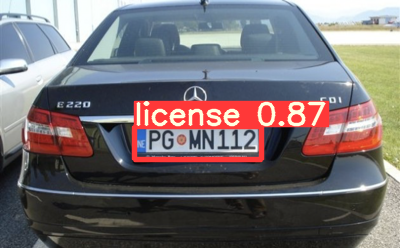

In [ ]:
l = len(output.split("\n"))
print (l)
path_result = output.split("\n")[l-3]

print (path_result)
path_img = path_result.split("to ")[1]
path_img = path_img.encode()
path_img = str(path_img).split("/")[2].split("\\")[0]
print(path_img)

path_img = "/content/yolov5/runs/detect/"+path_img+"/Cars1.png"
print(path_img)

import torch
from IPython.display import Image, clear_output  # to display images
Image(filename=path_img, width=600)


# Gradio


In [ ]:
!pip install gradio

     |████████████████████████████████| 2.2 MB 7.6 MB/s 
     |████████████████████████████████| 1.9 MB 51.0 MB/s 
     |████████████████████████████████| 206 kB 73.6 MB/s 
     |████████████████████████████████| 961 kB 65.7 MB/s 
     |████████████████████████████████| 63 kB 3.0 MB/s 
     |████████████████████████████████| 3.2 MB 24.1 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4709 sha256=cec9d663a7453a3a97abe4d2e07a2610d6a0d9827b5efaf7723f72641c83af0c
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3372 sha256=a53f56d39533c6813fd834f9271bf09a54167f8e9f7a0b441f4433d96bb58fc9
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [ ]:
# https://www.gradio.app/ml_examples

# Using saved model
import gradio as gr
import requests
import cv2
import subprocess as sp
from PIL import Image

def inference(img):
  my_image = img.name
  cmd = "python /content/yolov5/detect.py --save-txt --weights /content/best.pt  --conf 0.5 --source "+my_image
  output = sp.getoutput(cmd)
  l = len(output.split("\n"))
  path_result = output.split("\n")[l-3]
  path_img = path_result.split("to ")[1]
  path_img = path_img.encode()
  path_img = str(path_img).split("/")[2].split("\\")[0]
  file_name = "runs/detect/"+path_img+"/"+my_image.split("/")[2]
  img_result = Image.open(file_name)
  return img_result


gr.Interface(fn=inference, inputs=gr.inputs.Image(type="file"), 
             outputs=gr.outputs.Image()).launch(share=True) #debug=True Use in Colab

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://44705.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://44705.gradio.app')